# Обработка текстов

В этом ноутбуке проведем анализ текстовых комментариев к протоколам с использованием "интонационного" анализа.

Вопрос, на который отвечали учителя, заполняя каждый протокол, был следующим:  
**Выводы и идеи (Вы удовлетворены? Нужно ли что-то изменить? Какую достижимую цель вы хотели бы себе поставить? Понимаете ли вы, как ее достичь?)**

В большей части протоколов ответ на этот вопрос зафиксирован, но некоторые учителя оставили этот вопрос без ответа.

В первом полугодии 2022 года учителя фиксировали в протоколах только текстовые оценки проведенного урока, давая ответ на этот вопрос. Во втором полугодии начали использоваться доработанные протоколы, в которые были добавлены еще два вопроса, которые позволили зафиксировать степень удовлетворенности уроком.

Формулировки вопросов были следующими:
- **Удовлетворенность уроком** (варианты ответа: Да, Скорее да, Скорее нет, Нет)
- **Нужно ли что-то изменить** (варианты ответа: Да, Скорее да, Скорее нет, Нет)

В основном датафрейме проекта ответы на первый вопрос с текстовым значением хранятся в поле **teacher_comments**
Ответы на второй и третий вопросы - в полях **satisfaction**, **wish_to_change**.

В рамках этой части исследования попробуем научиться предсказывать ответы на второй и третий вопросы при условии, что в протоколе присутствует текстовый комментарий учителя.

Помимо предсказания этих оценок попробуем также использовать внешнюю оценку с привлечением экспертов. Для этого выделим верификационную выборку, текстовые комментарии в которых экспортируем во внешний файл и передадим его экспертам для оценки. Эту же верификационную выборку используем для проверки качества предсказания тех моделей, которые окажутся лучшими.

Есть также одно замечание по поводу текстовых комментариев. Хотя "по правилам игры" предполагалось, что этот комментарий будет писать учитель, который проводил урок, по факту часто это поле заполнял учитель, который проводил наблюдение. Это вносит в данные дополнительный "шум", увы.

1. [Загрузка библиотек](#load_libs)
2. [Загрузка данных](#load_data)
3. [Формирование выборки с полными данными](#build_data)
4. [Очистка текстов (лемматизация, стоп-слова)](#clear_texts)
5. [Формирование верификационной выборки из 200 текстовых комментариев (для экспертной оценки)](#build_verification_selection)
6. [Формирование обучающей и тестовой выборок](#build_train_test)
7. [Модель для предсказания степени удовлетворенности](#model_satisfaction)
8. [Модель для предсказания степени желания что-то изменить](#model_wish_to_change)
9. [Верификация моделей + верификация экспертных оценок](#verification)
10. [Облако слов (funny)](#wordcloud)

___
<a id='load_libs' name='load_libs'></a>
### 1. Загрузка библиотек
Загружаем стандартный набор библиотек, используемый в рамках этого исследования, и дополнительно загружаем библиотеки, которые потребуются для построения моделей, работы с текстами, оценки качества и т.д.

In [124]:
# Базовый набор библиотек
%run "./lib/load_big_libs.py"

# Библиотека SKLearn
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline

# Библиотеки для работы с текстами
from nltk.corpus import stopwords
import re
import nltk
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer

In [3]:
%run "./lib/data_lib.py"

___
<a id='load_data' name='load_data'></a>
### 2. Загружаем полный датафрейм

In [4]:
df_full = pd.read_csv("data/intermid/full_df_extended.csv", sep=';')
df_full.head()

,Unnamed: 0,prot_id,template_code,date_of_lesson,org_id,teacher_id,observer_id,curator_id,class,satisfaction,...,scope,pupils_m,pupils_d,attention_m,attention_d,interactions_m,interactions_d,vector_interact,vector_intention,vector_attention
0,0,816,П1.1,01.02.2022,133,726,725,724,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1162,П1.1,02.02.2022,128,736,735,734,NaN,NaN,...,0.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1170,П1.1,02.02.2022,128,735,736,734,NaN,NaN,...,0.818182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1069,П1.1,04.02.2022,133,725,726,724,NaN,NaN,...,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,295,П1.1,07.02.2022,79,534,533,532,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_full[['prot_id', 'teacher_comments','satisfaction', 'wish_to_change']].describe()

,prot_id,satisfaction,wish_to_change
count,3001.000000,1016.000000,952.000000
mean,1579.222926,3.485236,2.161765
std,890.060019,0.633839,0.972324
min,41.000000,1.000000,1.000000
25%,805.000000,3.000000,1.000000
50%,1575.000000,4.000000,2.000000
75%,2356.000000,4.000000,3.000000
max,3115.000000,4.000000,4.000000


___
<a id='build_data' name='build_data'></a>
### 3. Формирование полной выборки

Отбираем все протоколы, в которых присутствует текстовый комментарий учителя.

Оставляем в нем только интересующие нас колонки:
- prot_id
- satisfaction
- wish_to_change
- teacher_comment

In [18]:
df_texts = df_full[df_full['teacher_comments'].str.len() > 0][['prot_id', 'satisfaction', 'wish_to_change', 'teacher_comments']].copy()
df_texts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2890 entries, 0 to 3000
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   prot_id           2890 non-null   int64  
 1   satisfaction      989 non-null    float64
 2   wish_to_change    927 non-null    float64
 3   teacher_comments  2890 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 112.9+ KB


In [19]:
df_texts

,prot_id,satisfaction,wish_to_change,teacher_comments
0,816,NaN,NaN,Больше внимания уделять слабым ученикам и моти...
1,1162,NaN,NaN,Учитель уделяет внимание всем учащимся
2,1170,NaN,NaN,"Уделять внимание не только тем, кто поднимает ..."
3,1069,NaN,NaN,Больше внимания уделять слабым ученикам и моти...
4,295,NaN,NaN,Своё внимание учитель распределял на всех обу...
...,...,...,...,...
2996,2935,4.0,1.0,"Удовлетворена. Был урок русского языка, повтор..."
2997,2846,3.0,2.0,Уроком удовлетворена. Дети работали хорошо. Бу...
2998,2745,3.0,2.0,"Уроком удовлетворена, но не всегда довольна те..."
2999,3090,4.0,1.0,"Уроком удовлетворена, так как старалась, чтобы..."


___
<a id='clear_texts' name='clear_texts'></a>
### 4. Очистка текста
Для полученного датасета создадим дополнительную колонку, в которую поместим "очищенный" текст

In [ ]:
# Загружаем список стоп-слов
nltk.download('stopwords')

# Записываем в переменную стоп-слова русского языка
stopwords_ru = stopwords.words('russian')

In [143]:
# Напишем функцию для очистки текста
pymorphy2_analyzer = MorphAnalyzer()

def get_cleared_text(txt, stopwords):
    # Очищаем текст с помощью регулярных выражений
    text = re.sub(r'==.*?==+', '', txt) # удаляем лишние символы
    text = text.replace('\n', '') # удаляем знаки разделения на абзацы
    words = []
    # Выделим лексемы
    for word in text.split(' '):
        n_form = pymorphy2_analyzer.parse(word)[0].normal_form
        if len(n_form)>0:
            words.append(n_form)
    # Возвращаем очищенный текст, удаляя из него стоп-слова
    return ' '.join([wrd for wrd in words if wrd not in stopwords])



In [144]:
%%time
# Добавляем колонку с очищенными текстами, без стоп-слов
df_texts['text_without_stopwords'] = df_texts.apply(lambda x: get_cleared_text(x['teacher_comments'], stopwords_ru), axis=1)

# Добавляем колонку с очищенными текстами, но оставляя стоп-слова
df_texts['text_with_stopwords'] = df_texts.apply(lambda x: get_cleared_text(x['teacher_comments'], []), axis=1)

df_texts[['teacher_comments', 'text_without_stopwords', 'text_with_stopwords']].head(3)

Wall time: 1min 48s


,teacher_comments,text_without_stopwords,text_with_stopwords
0,Больше внимания уделять слабым ученикам и моти...,большой внимание уделять слабый ученик мотивир...,большой внимание уделять слабый ученик и мотив...
1,Учитель уделяет внимание всем учащимся,учитель уделять внимание весь учиться,учитель уделять внимание весь учиться
2,"Уделять внимание не только тем, кто поднимает ...","уделять внимание тем, поднимать руку.","уделять внимание не только тем, кто поднимать ..."


___
<a id='build_verification_selection' name='build_verification_selection'></a>
### 5. Формируем верификационную выборку из 200 записей
В выборку должны попасть как те записи, в которых поля satisfaction и wish_to_change содержат какие-то значения, так и те, где значения этих полей не определены.

In [145]:
# Формируем случайным образом выборку в 200 записей
df_sample42_200 = df_texts.sample(n=200, random_state=42)
#df_sample42_200.to_csv('data/intermid/sample42_200.csv', ';')

In [146]:
# Сразу же получаем полную выборку МИНУС верификационная выборка.
# Полученную выборку далее будем получать как основу для получения обучающей и тестовой выборок для каждой из моделей
df_texts_work = df_texts[~df_texts['prot_id'].isin(set(df_sample42_200['prot_id'].tolist()))]
df_texts_work.describe()

,prot_id,satisfaction,wish_to_change
count,2690.000000,919.000000,859.000000
mean,1577.262454,3.479869,2.190920
std,892.586295,0.637753,0.973237
min,42.000000,1.000000,1.000000
25%,795.750000,3.000000,1.000000
50%,1575.500000,4.000000,2.000000
75%,2357.750000,4.000000,3.000000
max,3115.000000,4.000000,4.000000


___
<a id='build_train_test' name='build_train_test'></a>
### 6. Формирование обучающих и тестовых выборок
Поскольку мы будем формировать отдельные модели для предсказания удовлетворенности и для желания что-то изменить, для каждой из моделей сформируем отдельные датафреймы.
Префикс S будем использовать для удовлетворенности (satisfaction), W - для желания что-то изменить (wish_to_change)

#### 6.0. Определяем функции для формирования выборок и для предсказаний

In [151]:
# Параметры функции:
# df - исходный датафрейм
# y_col - название колонки с предсказываемым значением
# x_col - название колонки, по которой проходит предсказание
# sep_value - граничное значение колонки y_col. Если значение колонки меньше этого порога, y=0, в противном случае y=1
# print_params - печатать ли результаты
def get_train_test(df, y_col, x_col, sep_value, print_params=True):
    df_ = df[~df[y_col].isnull()][['prot_id', x_col, y_col]]
    df_['y'] = df_[y_col].apply(lambda x: 0 if x < sep_value else 1)
    x_train, x_test, y_train, y_test = train_test_split(df_[x_col], df_['y'], test_size=0.2, random_state=42)
    if print_params:
        print(df_.describe())
        print(df_['y'].value_counts())
        print(f'Количество строк в обучающей выборке: {x_train.count()}')
        print(x_train[:3])
    return x_train, x_test, y_train, y_test

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 

# Функция для обучения модели.
# Выбрана логистическая регрессия. Используемые в функции параметры оказались в ходе экспериментов наиболее удачными
def fit_train(x_train, y_train):
    vec = TfidfVectorizer()
    bow = vec.fit_transform(x_train)
    classif = LogisticRegression(random_state=42, solver='liblinear', penalty='l2')
    #classif = LogisticRegression(random_state=42, solver='saga', penalty='l1')    
    classif.fit(bow, y_train)
    return vec, classif
    
def make_predict(vec, classif, x_test, y_test):
    pred = classif.predict(vec.transform(x_test))
    print(classification_report(pred, y_test))

#### 6.1. Формируем выборки для работы с параметром «Удовлетворение от проведенного урока»
Попробуем варианты предсказаний с тремя вариантами текстов:
1 - не очищенные исходные тексты
2 - преобразованные тексты без удаления стоп-слов
3 - преобразованные тексты после удаления стоп-слов

In [173]:
x_train_S1, x_test_S1, y_train_S1, y_test_S1 = get_train_test(df_texts_work, 'satisfaction', 'teacher_comments', 4)
x_train_S2, x_test_S2, y_train_S2, y_test_S2 = get_train_test(df_texts_work, 'satisfaction', 'text_with_stopwords', 4, False)
x_train_S3, x_test_S3, y_train_S3, y_test_S3 = get_train_test(df_texts_work, 'satisfaction', 'text_without_stopwords', 4, False)

           prot_id  satisfaction           y
count   919.000000    919.000000  919.000000
mean   2473.145811      3.479869    0.550598
std     387.657661      0.637753    0.497704
min      80.000000      1.000000    0.000000
25%    2165.500000      3.000000    0.000000
50%    2498.000000      4.000000    1.000000
75%    2803.500000      4.000000    1.000000
max    3107.000000      4.000000    1.000000
1    506
0    413
Name: y, dtype: int64
Количество строк в обучающей выборке: 735
2256    Да. Нет. Работать продуктивно над качеством об...
2819    Уроком удовлетворена. Развивать речь, пополнят...
372     Урок был проведен по плану, но слабые дети не ...
Name: teacher_comments, dtype: object


#### 6.2. Формируем выборки для работы с параметром «Желание что-то изменить»
Повторим те же варианты предсказаний с тремя вариантами текстов:
1 - не очищенные исходные тексты
2 - преобразованные тексты без удаления стоп-слов
3 - преобразованные тексты после удаления стоп-слов

In [174]:
x_train_W1, x_test_W1, y_train_W1, y_test_W1 = get_train_test(df_texts_work, 'wish_to_change', 'teacher_comments', 3)
x_train_W2, x_test_W2, y_train_W2, y_test_W2 = get_train_test(df_texts_work, 'wish_to_change', 'text_with_stopwords', 3, False)
x_train_W3, x_test_W3, y_train_W3, y_test_W3 = get_train_test(df_texts_work, 'wish_to_change', 'text_without_stopwords', 3, False)

           prot_id  wish_to_change           y
count   859.000000      859.000000  859.000000
mean   2501.831199        2.190920    0.353900
std     371.701099        0.973237    0.478457
min    1735.000000        1.000000    0.000000
25%    2216.500000        1.000000    0.000000
50%    2525.000000        2.000000    0.000000
75%    2819.500000        3.000000    1.000000
max    3107.000000        4.000000    1.000000
0    555
1    304
Name: y, dtype: int64
Количество строк в обучающей выборке: 687
175     Работой удовлетворена. Вниманием охвачены все ...
1515           Уроком довольна. Менять  ничего не нужно. 
1170    Цели поставленные на уроке достигнуты. Уроком ...
Name: teacher_comments, dtype: object


___
<a id='model_satisfaction' name='model_satisfaction'></a>
### 7. Модель для предсказания степени удовлетворенности

Сравним предсказания по трем вариантам текстов, используя TF-IDF

Для предсказания используется модель логистической регрессии 

В качестве параметров были экспериментальным образом отобраны те, которые позволили на текущей выборке получить лучшие результаты:

solver='liblinear', penalty='l2'

In [175]:
print('Предсказания степени удовлетворенности на исходных текстах')
vec_S1, classif_S1 = fit_train(x_train_S1, y_train_S1)
make_predict(vec_S1, classif_S1, x_test_S1, y_test_S1)

Предсказания степени удовлетворенности на исходных текстах
              precision    recall  f1-score   support

           0       0.49      0.69      0.57        64
           1       0.79      0.62      0.69       120

    accuracy                           0.64       184
   macro avg       0.64      0.65      0.63       184
weighted avg       0.68      0.64      0.65       184



In [176]:
print('Предсказания степени удовлетворенности на преобразованных текстах без удаления стоп-слов')
vec_S2, classif_S2 = fit_train(x_train_S2, y_train_S2)
make_predict(vec_S2, classif_S2, x_test_S2, y_test_S2)

Предсказания степени удовлетворенности на преобразованных текстах без удаления стоп-слов
              precision    recall  f1-score   support

           0       0.47      0.65      0.54        65
           1       0.76      0.60      0.67       119

    accuracy                           0.61       184
   macro avg       0.61      0.62      0.60       184
weighted avg       0.65      0.61      0.62       184



In [177]:
print('Предсказания степени удовлетворенности на преобразованных текстах с удалением стоп-слов')
vec_S3, classif_S3 = fit_train(x_train_S3, y_train_S3)
make_predict(vec_S3, classif_S3, x_test_S3, y_test_S3)

Предсказания степени удовлетворенности на преобразованных текстах с удалением стоп-слов
              precision    recall  f1-score   support

           0       0.42      0.61      0.50        62
           1       0.74      0.57      0.65       122

    accuracy                           0.59       184
   macro avg       0.58      0.59      0.57       184
weighted avg       0.64      0.59      0.60       184



##### Выводы по предсказанию степени удовлетворенности

Результаты получились очень плохими, и интересно то, что лучшие результаты были получены с "сырым", не обработанным текстом.

Более надежно предсказывается удовлетворенность уроком, чем не-удовлетворенность.

___
<a id='model_wish_to_change' name='model_wish_to_change'></a>
### 8. Модель для предсказания желания что-то изменить при проведении последующих уроков

Точно так же сравним предсказания по трем вариантам текстов, используя TF-IDF

Для предсказания используется модель логистической регрессии 


In [178]:
print('Предсказания желания что-то изменить на исходных текстах')
vec_W1, classif_W1 = fit_train(x_train_W1, y_train_W1)
make_predict(vec_W1, classif_W1, x_test_W1, y_test_W1)

Предсказания желания что-то изменить на исходных текстах
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       147
           1       0.30      0.68      0.42        25

    accuracy                           0.73       172
   macro avg       0.62      0.71      0.62       172
weighted avg       0.84      0.73      0.76       172



In [179]:
print('Предсказания желания что-то изменить на преобразованных текстах без удаления стоп-слов')
vec_W2, classif_W2 = fit_train(x_train_W2, y_train_W2)
make_predict(vec_W2, classif_W2, x_test_W2, y_test_W2)

Предсказания желания что-то изменить на преобразованных текстах без удаления стоп-слов
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       147
           1       0.34      0.76      0.47        25

    accuracy                           0.75       172
   macro avg       0.64      0.75      0.65       172
weighted avg       0.86      0.75      0.78       172



In [180]:
print('Предсказания желания что-то изменить на преобразованных текстах с удалением стоп-слов')
vec_W3, classif_W3 = fit_train(x_train_W3, y_train_W3)
make_predict(vec_W3, classif_W3, x_test_W3, y_test_W3)

Предсказания желания что-то изменить на преобразованных текстах с удалением стоп-слов
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       149
           1       0.32      0.78      0.46        23

    accuracy                           0.75       172
   macro avg       0.64      0.76      0.65       172
weighted avg       0.87      0.75      0.79       172



#### Выводы по анализу степени желания что-то изменить
В случае с предсказанием этой самооценки результаты комплексного показателя качества F1-score улучшились для лемматизированного текста и мало отличаются при использовании стоп-слов или без их удаления. Гораздо точнее при этом предсказывается нежелание что-то изменить в будущих уроках. Точность же предсказания желания что-то изменить мало отличается от случайного выбора - оан не достигает и 50 процентов.

Проблема с предсказанием может быть связана со многими факторами, попытаемся проанализировать их в конце исследования.

___
<a id='verification' name='verification'></a>
### 9. Верификация моделей + верификация экспертных оценок

На этом этапе проделаем следующий эксперимент.

1. У нас есть отобранные ранее 200 протоколов, в которых заполнено поле teacher_comments
2. Часть протоколов из этих двухсот - с заполненными полями satisfaction и wish_to_change, а часть - с незаполненными.
3. Есть отдельный файл, в котором эксперт попытался, читая текстовые комментарии в этих 200 протоколах, дать ответы на вопросы о степени удовлетворения и желании что-то изменить, ориентируясь на текст комментария и свою интуицию.

Мы можем сделать следующее:
1. Попытаться с помощью показавших себя лучшими моделей предсказать для верификационной выборки с помощью логистической регрессии ответы на вопросы satisfaction и wish_to_change. В результате у нас будет полный набор предсказаний.
2. Мы можем отобрать из 200 протоколов те протоколы, для которых учитель самостоятельно заполнил поля satisfaction и wish_to_change, и оценить точность предсказаний моделей на этой верификационной выборке.
3. Также мы можем сравнить точность экспертного предсказания по этим протоколам.
4. Мы можем для всех 200 протоколов сравнить оценки эксперта и предсказаний моделей.

В зависимости от того, что мы увидим в результате, попробуем сформулировать выводы.

#### 9.1 Объединяем в один датафрейм данные

In [184]:
# Исходный верификационный датафрейм из 200 записей
df_sample42_200.head()

,prot_id,satisfaction,wish_to_change,teacher_comments,text,text_without_stopwords,text_with_stopwords
493,1238,NaN,NaN,"Учитель тактично ввел в беседу мишень2, постеп...","учитель тактично ввести беседа мишень2, постеп...","учитель тактично ввести беседа мишень2, постеп...","учитель тактично ввести в беседа мишень2, пост..."
1255,281,NaN,NaN,Увеличить количество продуктивных вопросов,увеличить количество продуктивный вопрос,увеличить количество продуктивный вопрос,увеличить количество продуктивный вопрос
2470,2538,3.0,4.0,Думаю да. Один ребенок на контакт не пошел. Ну...,думать да. ребёнок контакт пошел. нужно большо...,думать да. ребёнок контакт пошел. нужно большо...,думать да. один ребёнок на контакт не пошел. н...
2887,2779,3.0,2.0,Этим уроком довольна. На данном этапе ничего м...,это урок довольна. данный этап менять буду.,это урок довольна. данный этап менять буду.,это урок довольна. на данный этап ничего менят...
2997,2846,3.0,2.0,Уроком удовлетворена. Дети работали хорошо. Бу...,урок удовлетворена. ребёнок работать хорошо. д...,урок удовлетворена. ребёнок работать хорошо. д...,урок удовлетворена. ребёнок работать хорошо. б...


In [187]:
# Загружаем датафрейм с оценками эксперта
df_expert = pd.read_csv('data/external/expert_1.csv', sep=';')
df_expert.head()

,Unnamed: 0,prot_id,satisfaction,wish_to_change,teacher_comments,satisfaction_expert,wish_to_change_expert
0,493,1238,NaN,NaN,"Учитель тактично ввел в беседу мишень2, постеп...",Скорее да,Нет
1,1255,281,NaN,NaN,Увеличить количество продуктивных вопросов,Не определено,Скорее да
2,2470,2538,3.0,4.0,Думаю да. Один ребенок на контакт не пошел. Ну...,Скорее да,Скорее да
3,2887,2779,3.0,2.0,Этим уроком довольна. На данном этапе ничего м...,Да,Нет
4,2997,2846,3.0,2.0,Уроком удовлетворена. Дети работали хорошо. Бу...,Да,Скорее нет


In [213]:
# Создаем копию верификаццонного датафрейма и добавим в него колонки с оценками учителей и оценками эксперта, приведенными к формату значений 0 - 1
df_sample = df_sample42_200.copy()
df_sample['satisfaction_t'] = df_sample.apply(lambda x: 1 if x['satisfaction'] > 3.0 else (0 if x['satisfaction'] > 0.0 else np.nan), axis=1)
df_sample['wish_t'] = df_sample.apply(lambda x: 1 if x['wish_to_change'] > 2.0 else (0 if x['wish_to_change'] > 0.0 else np.nan), axis=1)
df_expert['satisfaction_e'] = df_expert.apply(lambda x: 1 if x['satisfaction_expert'] in ['Да'] else 0, axis=1)
df_expert['wish_e'] = df_expert.apply(lambda x: 1 if x['wish_to_change_expert'] in ['Да', 'Скорее да'] else 0, axis=1)

df_sample = df_sample.join(df_expert[['prot_id', 'satisfaction_e', 'wish_e']].set_index('prot_id'), on='prot_id')
df_sample.reset_index(inplace=True)
df_sample.head(5)

,index,prot_id,satisfaction,wish_to_change,teacher_comments,text,text_without_stopwords,text_with_stopwords,satisfaction_t,wish_t,satisfaction_e,wish_e
0,493,1238,NaN,NaN,"Учитель тактично ввел в беседу мишень2, постеп...","учитель тактично ввести беседа мишень2, постеп...","учитель тактично ввести беседа мишень2, постеп...","учитель тактично ввести в беседа мишень2, пост...",NaN,NaN,0,0
1,1255,281,NaN,NaN,Увеличить количество продуктивных вопросов,увеличить количество продуктивный вопрос,увеличить количество продуктивный вопрос,увеличить количество продуктивный вопрос,NaN,NaN,0,1
2,2470,2538,3.0,4.0,Думаю да. Один ребенок на контакт не пошел. Ну...,думать да. ребёнок контакт пошел. нужно большо...,думать да. ребёнок контакт пошел. нужно большо...,думать да. один ребёнок на контакт не пошел. н...,0.0,1.0,0,1
3,2887,2779,3.0,2.0,Этим уроком довольна. На данном этапе ничего м...,это урок довольна. данный этап менять буду.,это урок довольна. данный этап менять буду.,это урок довольна. на данный этап ничего менят...,0.0,0.0,1,0
4,2997,2846,3.0,2.0,Уроком удовлетворена. Дети работали хорошо. Бу...,урок удовлетворена. ребёнок работать хорошо. д...,урок удовлетворена. ребёнок работать хорошо. д...,урок удовлетворена. ребёнок работать хорошо. б...,0.0,0.0,1,0


#### 9.2 Делаем предсказания

##### Выбираем лучшую модель для предсказания Удовлетворенности и получаем предсказания для всех 200 протоколов

In [214]:
pred_verif_S = classif_S1.predict(vec_S1.transform(df_sample['teacher_comments'].tolist()))
print(pred_verif_S)
# Добавляем колонку с предсказаниями к датафрейму
df_sample['pred_S'] = pd.Series(pred_verif_S)
df_sample.head(5)


[1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0
 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1
 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1]


,index,prot_id,satisfaction,wish_to_change,teacher_comments,text,text_without_stopwords,text_with_stopwords,satisfaction_t,wish_t,satisfaction_e,wish_e,pred_S
0,493,1238,NaN,NaN,"Учитель тактично ввел в беседу мишень2, постеп...","учитель тактично ввести беседа мишень2, постеп...","учитель тактично ввести беседа мишень2, постеп...","учитель тактично ввести в беседа мишень2, пост...",NaN,NaN,0,0,1
1,1255,281,NaN,NaN,Увеличить количество продуктивных вопросов,увеличить количество продуктивный вопрос,увеличить количество продуктивный вопрос,увеличить количество продуктивный вопрос,NaN,NaN,0,1,0
2,2470,2538,3.0,4.0,Думаю да. Один ребенок на контакт не пошел. Ну...,думать да. ребёнок контакт пошел. нужно большо...,думать да. ребёнок контакт пошел. нужно большо...,думать да. один ребёнок на контакт не пошел. н...,0.0,1.0,0,1,0
3,2887,2779,3.0,2.0,Этим уроком довольна. На данном этапе ничего м...,это урок довольна. данный этап менять буду.,это урок довольна. данный этап менять буду.,это урок довольна. на данный этап ничего менят...,0.0,0.0,1,0,1
4,2997,2846,3.0,2.0,Уроком удовлетворена. Дети работали хорошо. Бу...,урок удовлетворена. ребёнок работать хорошо. д...,урок удовлетворена. ребёнок работать хорошо. д...,урок удовлетворена. ребёнок работать хорошо. б...,0.0,0.0,1,0,1


##### Выбираем лучшую модель для предсказания Желания что-то изменить и получаем предсказания для всех 200 протоколов

In [238]:
pred_verif_W = classif_W1.predict(vec_W1.transform(df_sample['teacher_comments'].tolist()))
print(pred_verif_W)
# Добавляем колонку с предсказаниями к датафрейму
df_sample['pred_W'] = pd.Series(pred_verif_W)
df_sample.head(5)


[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


,index,prot_id,satisfaction,wish_to_change,teacher_comments,text,text_without_stopwords,text_with_stopwords,satisfaction_t,wish_t,satisfaction_e,wish_e,pred_S,pred_W
0,493,1238,NaN,NaN,"Учитель тактично ввел в беседу мишень2, постеп...","учитель тактично ввести беседа мишень2, постеп...","учитель тактично ввести беседа мишень2, постеп...","учитель тактично ввести в беседа мишень2, пост...",NaN,NaN,0,0,1,0
1,1255,281,NaN,NaN,Увеличить количество продуктивных вопросов,увеличить количество продуктивный вопрос,увеличить количество продуктивный вопрос,увеличить количество продуктивный вопрос,NaN,NaN,0,1,0,1
2,2470,2538,3.0,4.0,Думаю да. Один ребенок на контакт не пошел. Ну...,думать да. ребёнок контакт пошел. нужно большо...,думать да. ребёнок контакт пошел. нужно большо...,думать да. один ребёнок на контакт не пошел. н...,0.0,1.0,0,1,0,1
3,2887,2779,3.0,2.0,Этим уроком довольна. На данном этапе ничего м...,это урок довольна. данный этап менять буду.,это урок довольна. данный этап менять буду.,это урок довольна. на данный этап ничего менят...,0.0,0.0,1,0,1,0
4,2997,2846,3.0,2.0,Уроком удовлетворена. Дети работали хорошо. Бу...,урок удовлетворена. ребёнок работать хорошо. д...,урок удовлетворена. ребёнок работать хорошо. д...,урок удовлетворена. ребёнок работать хорошо. б...,0.0,0.0,1,0,1,0


#### 9.3. Сравним предсказания модели с реальными выборами учителей

In [232]:
# Получаем фрагмент датафрейма, для которого есть оценка успешности, данная учителем
df_sample_S = df_sample[~df_sample['satisfaction'].isna()].copy()
print(classification_report(df_sample_S['pred_S'].tolist(), df_sample_S['satisfaction_t'].tolist()))

              precision    recall  f1-score   support

           0       0.47      0.84      0.60        19
           1       0.92      0.65      0.76        51

    accuracy                           0.70        70
   macro avg       0.69      0.74      0.68        70
weighted avg       0.80      0.70      0.72        70



In [239]:
# Получаем фрагмент датафрейма, для которого есть оценка успешности, данная учителем
df_sample_W = df_sample[~df_sample['wish_to_change'].isna()].copy()
print(classification_report(df_sample_W['pred_W'].tolist(), df_sample_W['wish_t'].tolist()))

              precision    recall  f1-score   support

           0       0.94      0.73      0.82        60
           1       0.24      0.62      0.34         8

    accuracy                           0.72        68
   macro avg       0.59      0.68      0.58        68
weighted avg       0.85      0.72      0.77        68



#### 9.4. Сравним оценки эксперта с реальными выборами учителей

In [234]:
print(classification_report(df_sample_S['satisfaction_e'].tolist(), df_sample_S['satisfaction_t'].tolist()))

              precision    recall  f1-score   support

           0       0.50      0.61      0.55        28
           1       0.69      0.60      0.64        42

    accuracy                           0.60        70
   macro avg       0.60      0.60      0.59        70
weighted avg       0.62      0.60      0.60        70



In [240]:
print(classification_report(df_sample_W['wish_e'].tolist(), df_sample_W['wish_t'].tolist()))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        47
           1       0.62      0.62      0.62        21

    accuracy                           0.76        68
   macro avg       0.72      0.72      0.72        68
weighted avg       0.76      0.76      0.76        68



#### 9.5. Сравним оценки эксперта с предсказаниями моделей
В данном случае у нас есть 200 предсказаний и 200 оценок эксперта, т.е. проверяем на бОльшем количестве данных.

In [236]:
print(classification_report(df_sample['satisfaction_e'].tolist(), df_sample['pred_S'].tolist()))

              precision    recall  f1-score   support

           0       0.69      0.40      0.50        86
           1       0.66      0.87      0.75       114

    accuracy                           0.67       200
   macro avg       0.67      0.63      0.63       200
weighted avg       0.67      0.67      0.64       200



In [241]:
print(classification_report(df_sample['wish_e'].tolist(), df_sample['pred_W'].tolist()))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       126
           1       0.81      0.30      0.44        74

    accuracy                           0.71       200
   macro avg       0.76      0.63      0.62       200
weighted avg       0.74      0.71      0.67       200



#### Выводы по использованию экспертных оценок
Полученные результаты сравнений прежде всего показывают, что экспертные предсказания оценок на верификационной выборке не лучше предсказаний моделей. При предсказании степени удовлетворенности учителя экспертные оценки оказались заметно хуже оценок модели, при предсказании желания что-то изменить экспертная оценка незначительно превысила по качеству оценку модели.

Кроме того, прямое сравнение предсказаний, данных экспертом и моделями, показывает примерно такой же невысокий уровень совпадения.

Объяснений полученным результатам может быть несколько:
1. Формулировки вопросов, на которые отвечали учителя и на которые пытался отвечать эксперт, разными учителями могли восприниматься по-разному.
2. Текстовые комментарии, которые писали учителя, не всегда могли отражать полностью реальное отношение учителя. Оценки по удовлетворенности явно "задраны" вверх. Именно поэтому при построении модели для интерпретации ответов на этот вопрос было принято решение, что любой ответ кроме Да считался отрицательным.
3. Интересно, что и при предсказании эксперта, и при предсказании с помощью модели оценки вопроса о степени согласия оказались более точными для предсказания ответа Да, причем у модели уровень предсказания оказался выше 90 процентов. В то же время предсказание отрицательного ответа - ниже 50 процентов.
4. В свою очередь для предсказания ответа на вопрос о желании что-то изменить и модель, и эксперт довольно неплохо (с точностью более 80 процентов) предсказывали НЕжелание что-то менять. Зато эксперту удалось более точно, чем модели, "ловить" ответ Да (Скорее да) на этот вопрос (точность более 60 процентов, в то время как у модели - всего лишь 34).
5. Конечно, значимый фактор, повлиявший и на качество модели, и на общую точность, которая, возможно, могла бы даже уменьшиться для той же модели, связано с небольшим объемом выборки.

Очевидно, что для того, чтобы эти метрики стали более значимыми при анализе результатов исследования, для новых школьных групп, которые будут проходить обучение в рамках проекта Кураторская методика, необходимо будет предложить другие формулировки вопросов и больше внимания уделить знакомству учителей с рекомендациями по заполнению этих полей. Хотелось бы иметь возможность на основании этих данных генерировать для учителей рекомендации по ходу реализации проекта.


___
<a id='wordcloud' name='wordcloud'></a>
### 10. Облако слов
Попытка посмотреть на наиболее популярные слова, использованные учителями при написании своих комментариев к проведенным урокам

Для этого используем библиотеку [wordcloud](https://pypi.org/project/wordcloud/)

Для анализа используем слова из колонки **text_without_stopwords** из полного датафрейма

In [181]:
# Определяем функцию для отображения облака
def plot_cloud(wordcloud):
    # Устанавливаем размер картинки
    plt.figure(figsize=(40, 30))
    
    # Показать изображение
    plt.imshow(wordcloud) 
    
    # Без подписей на осях
    plt.axis("off")

In [182]:
# Объединяем в один текст все значения поля text_without_stopwords
text = ''
for comment in df_texts['text_without_stopwords'].tolist():
    text += ' ' + comment   


Wall time: 29.3 s


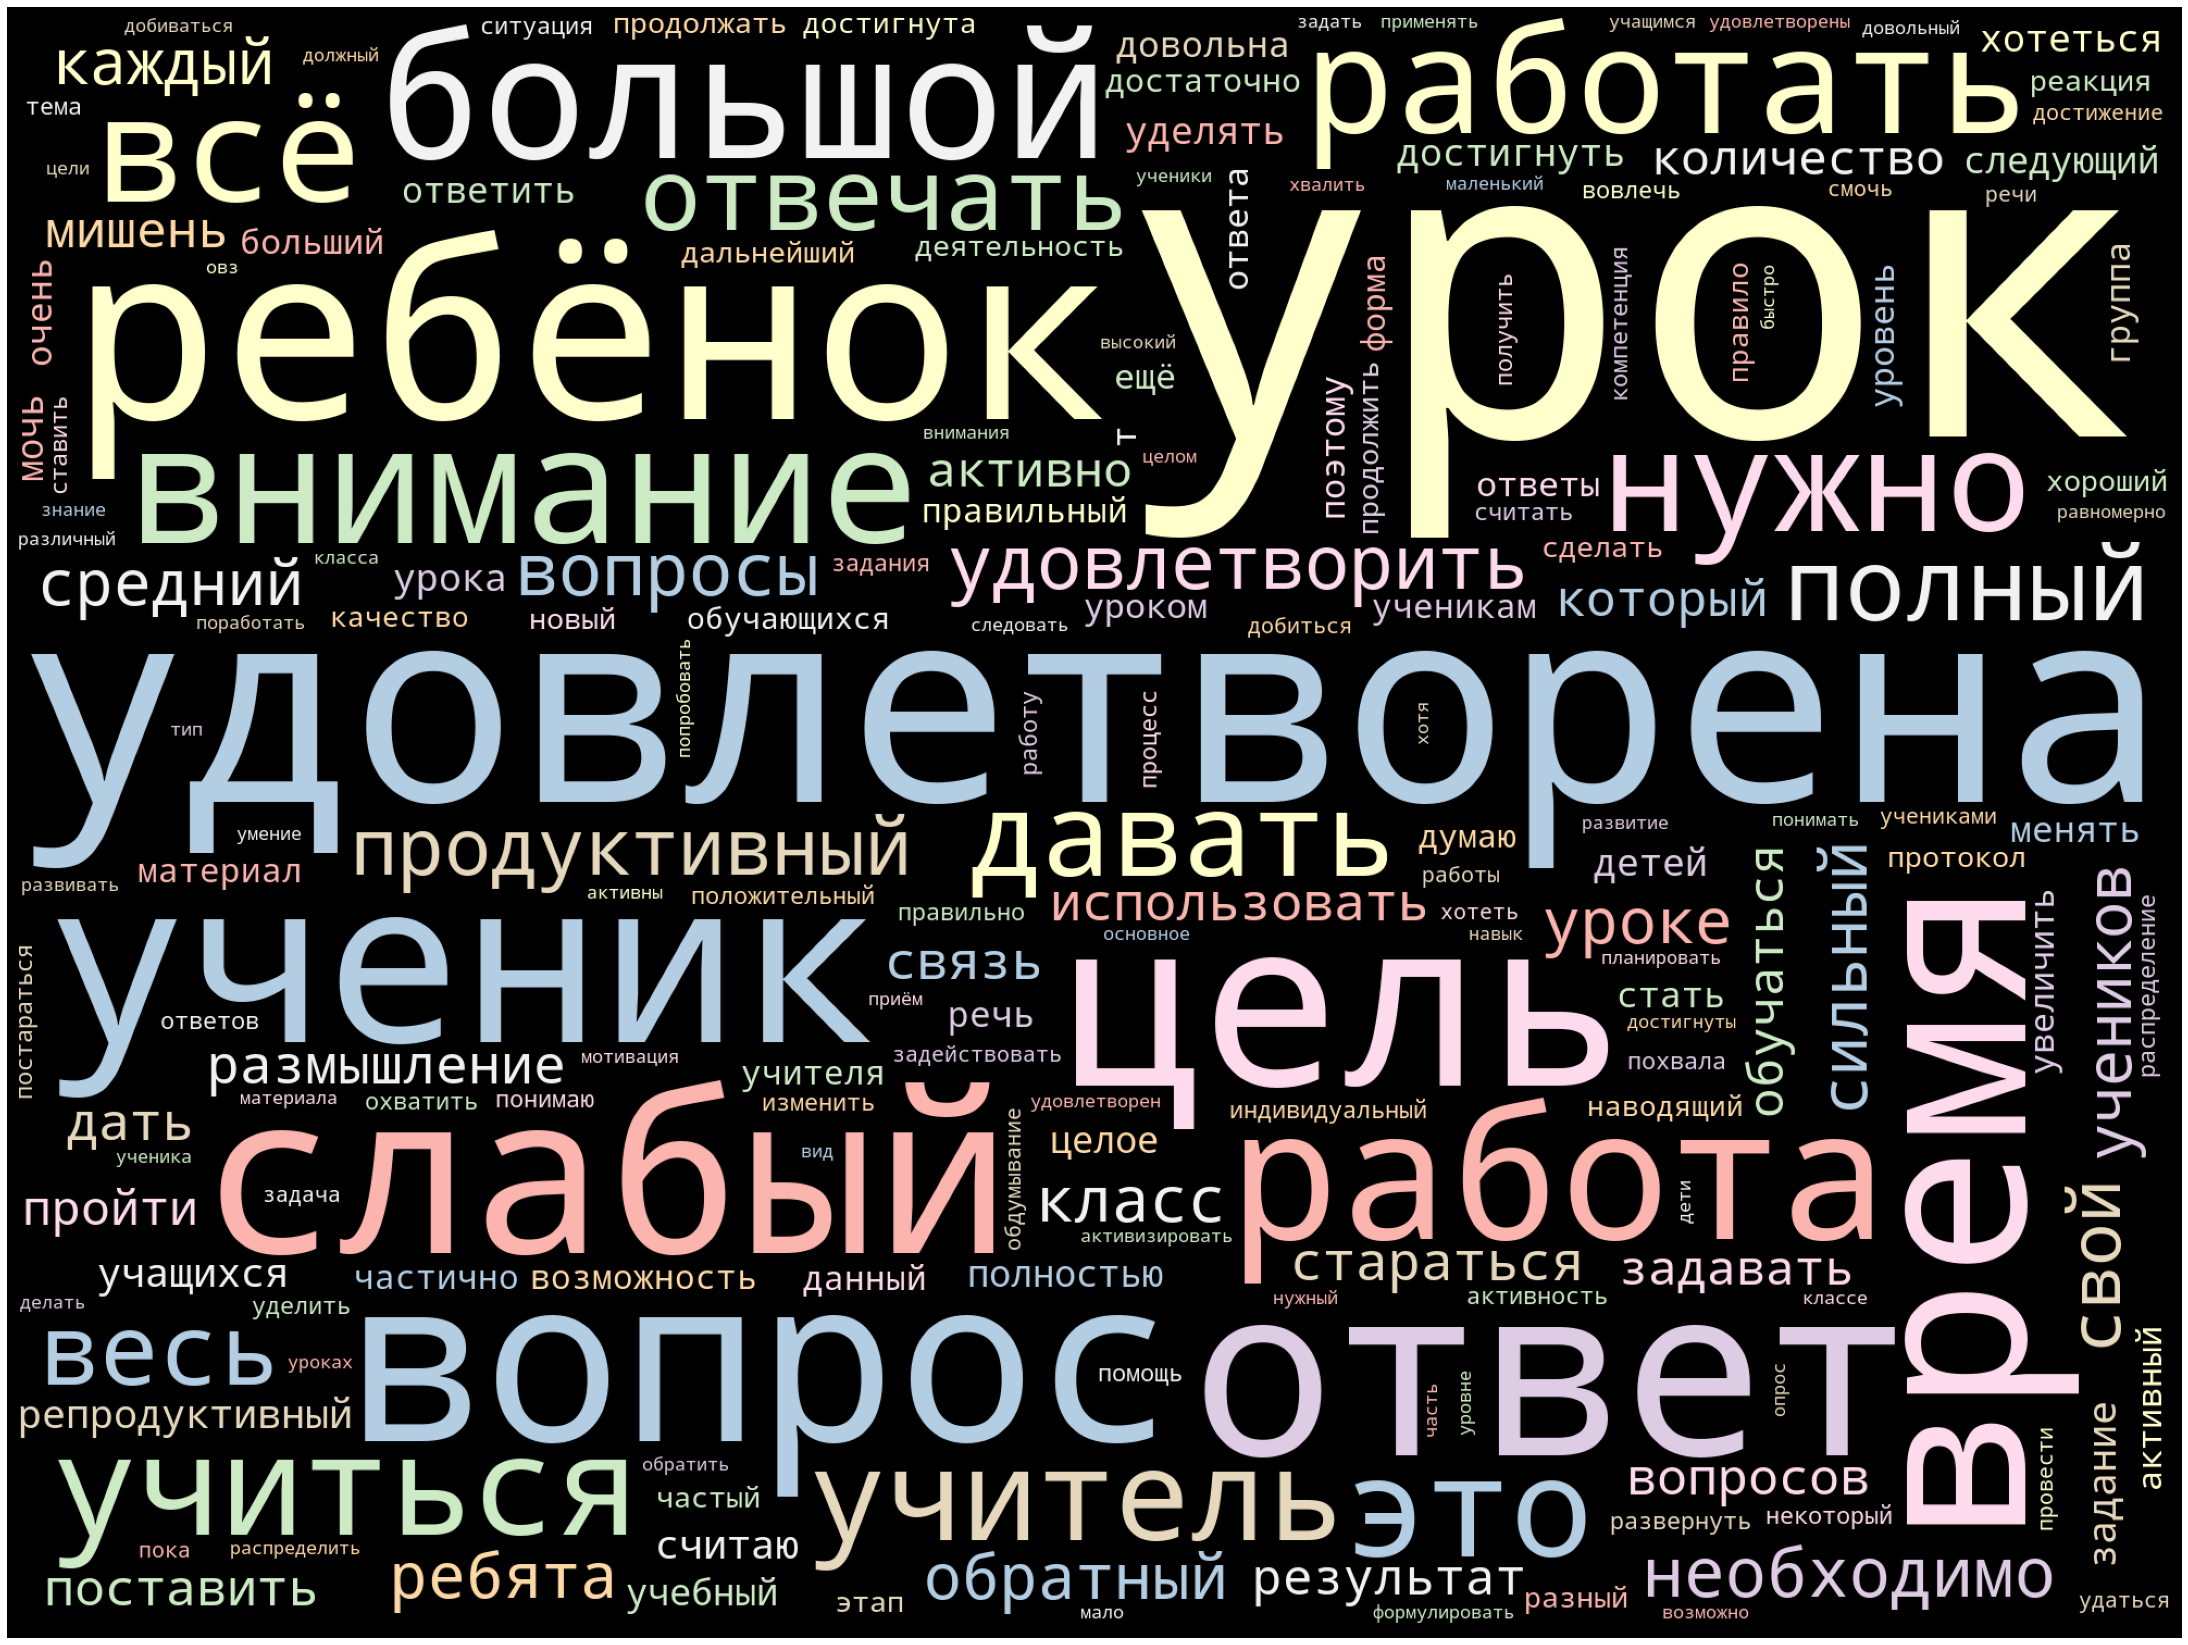

In [183]:
%%time
# Генерируем облако слов
wordcloud = WordCloud(width = 2000, 
                      height = 1500, 
                      random_state=42, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False, 
                      stopwords = stopwords_ru).generate(text)

# Рисуем картинку
plot_cloud(wordcloud)

In [242]:
# сохраняем облако слов в графическом файле
wordcloud.to_file('wordcloud.png')